# HW4 - Applied ML

There are four aspects:
* First, we process the data and explore the dataset (0).
* Then, we classify labels. (1).
* We plot learning curves (Bonus)
* Finally, we do clustering (2).

## 0. Data Pre-Processing and Visualization
Understanding the dataset, cleaning the variables. This is important because later we will need clean data for supervised and unsupervised learning.

Using http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb, we will clean the dataset. Then, we will aggregate information. Finally, we will clean up the features.

### Pre-Processing Tasks and Outline

1) Dataset cleaning
- exclude interactions by  ref who feature in fewer than 22 diyads

- drop NAs with no race values, averaging race values

2) Aggregate to player data

- combine games, referee and bias information using variable statistics

3) Cleaning features

- take out unnecessary features — player ID, photo ID
- turning date into proper format

- convert categorical variables into dummy variables


In [279]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import sklearn.cross_validation
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
%matplotlib inline

In [2]:
df = pd.read_csv('Data/CrowdstormingDataJuly1st.csv')

In [3]:
orig_num_dyads = df.shape[0]
print('Number of dyads:', orig_num_dyads)

Number of dyads: 146028


## 1. Dataset Cleaning

### Exclude Interactions

In [4]:
#This line defines a new dataframe based on our >21 games filter
all_refs = df.refNum.value_counts()
good_refs = all_refs[all_refs>21]

df=df[df['refNum'].isin(good_refs.index.values)]

In [5]:
print('percentage of dyads left:', 100 * df.shape[0] / orig_num_dyads)

percentage of dyads left: 91.4215082039061


### Getting Race Values

Get the real "race value" by taking the average of the two. Then drop the ones that don't have rating.

In [6]:
# We verify that it is never the case that only one of the rater field is NaN
df[((df.rater1.notnull()) & (df.rater2.isnull())) | ((df.rater1.isnull()) & (df.rater2.notnull()))]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp


In [7]:
df['race_val'] = (df['rater1'] + df['rater2'])/2
df.dropna(subset=['race_val'],inplace=True)

In [8]:
print('percentage of dyads left:', 100 * df.shape[0] / orig_num_dyads)

percentage of dyads left: 77.9727175610157


In [9]:
df_new=df.copy()
df_new.drop(['rater1','rater2','player','photoID','Alpha_3','birthday', 'refNum'],axis=1, inplace=True)
df_new.isnull().any()

playerShort      False
club             False
leagueCountry    False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
refCountry       False
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
race_val         False
dtype: bool

Taking care of null values

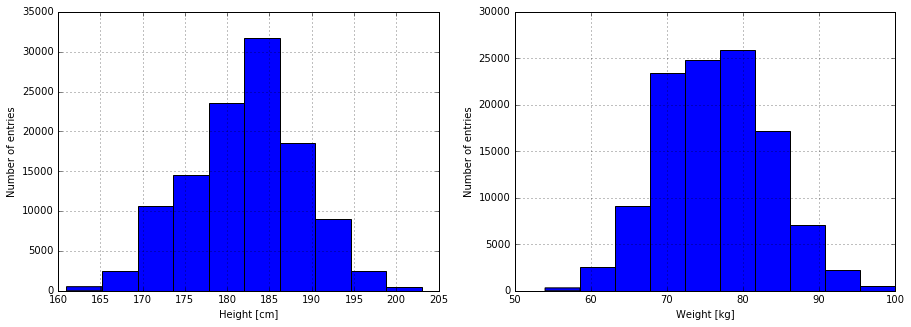

In [10]:
# TODO label axes
fig, axs = plt.subplots(1,2,  figsize=(15, 5))

df_new['height'].hist(ax=axs[0])
axs[0].set_ylabel('Number of entries')
axs[0].set_xlabel('Height [cm]')
df_new['weight'].hist(ax=axs[1])
axs[1].set_ylabel('Number of entries')
axs[1].set_xlabel('Weight [kg]')

In [11]:
mean_weight = df_new['weight'][df_new.weight.notnull()].mean()
mean_height = df_new['height'][df_new.height.notnull()].mean()
print(mean_weight, mean_height)
df_new['weight'].fillna(mean_weight, inplace=True)
df_new['height'].fillna(mean_height, inplace=True)

76.31274230154455 182.0956877695693


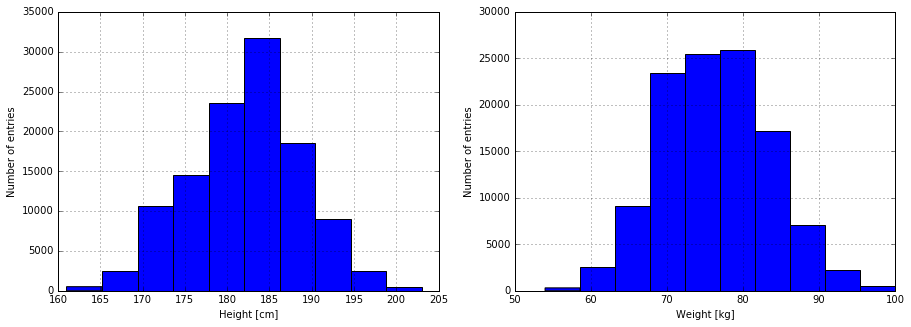

In [12]:
fig, axs = plt.subplots(1,2,  figsize=(15, 5))

df_new['height'].hist(ax=axs[0])
axs[0].set_ylabel('Number of entries')
axs[0].set_xlabel('Height [cm]')
df_new['weight'].hist(ax=axs[1])
axs[1].set_ylabel('Number of entries')
axs[1].set_xlabel('Weight [kg]')

In [13]:
print(df_new[df_new.meanIAT.isnull()]['refCountry'].unique(),
df_new[df_new.nIAT.isnull()]['refCountry'].unique(),
df_new[df_new.seIAT.isnull()]['refCountry'].unique(),
df_new[df_new.meanExp.isnull()]['refCountry'].unique(),
df_new[df_new.nExp.isnull()]['refCountry'].unique(),
df_new[df_new.seExp.isnull()]['refCountry'].unique())


[ 16 138] [ 16 138] [ 16 138] [ 16 138] [ 16 138] [ 16 138]


In [14]:
# Not many NAs so we drop them
df_new[df_new.meanIAT.isnull()].shape

(110, 22)

In [15]:
df_new.shape

(113862, 22)

In [16]:
# TODO: Add explanation for why not dropping NAs
df_new['position'].fillna('NA', inplace=True)

In [17]:
df_new.dropna(inplace=True)

Covert categorical data to numerical values

In [18]:
cols = ['club', 'leagueCountry', 'position']
df_cat = df_new[cols].apply(LabelEncoder().fit_transform)

In [19]:
df_new.drop(cols, axis=1, inplace=True)
df_categorized = pd.concat([df_new, df_cat], axis=1)


In [20]:
df_categorized.reset_index(drop=True, inplace = True)
df_categorized.head()

,playerShort,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,race_val,club,leagueCountry,position
0,aaron-hughes,182.0,71.0,1,0,0,1,0,0,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,34,0,1
1,aleksandar-kolarov,187.0,80.0,1,1,0,0,0,0,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,48,0,6
2,alexander-tettey,180.0,68.0,1,0,0,1,0,0,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,54,0,4
3,anders-lindegaard,193.0,80.0,1,0,1,0,0,0,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250,49,0,5
4,andreas-beck,180.0,70.0,1,1,0,0,0,0,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,2,2,10


In [21]:
df_categorized.isnull().any()

playerShort      False
height           False
weight           False
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
refCountry       False
meanIAT          False
nIAT             False
seIAT            False
meanExp          False
nExp             False
seExp            False
race_val         False
club             False
leagueCountry    False
position         False
dtype: bool

It remains to aggregate the data by player before applying the Machine learning methods

In [22]:
# each set of columns will be aggregated differently

# basis
player_cols = ['playerShort'] 

#sum
game_cols = ['games','victories','ties','defeats','goals','yellowCards','yellowReds','redCards']

#mode
ref_cols = ['refCountry' ]#, 'height', 'weight', 'club', 'leagueCountry', 'position'] 

#mean
bias_mean_cols = ['meanIAT','meanExp', 'race_val', 'height', 'weight', 'club', 'leagueCountry', 'position'] 

#sum
bias_n_cols = ['nIAT','nExp'] 

#special function
bias_se_cols = ['seIAT', 'seExp'] 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ad852b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11adcbd68>]], dtype=object)

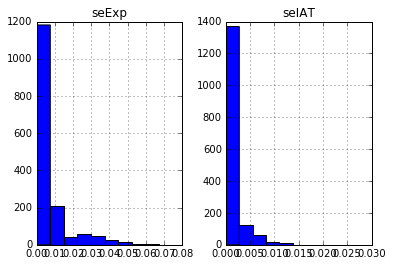

In [29]:

df_categorized.groupby(player_cols)[bias_se_cols].std().hist()

In [30]:
df_aggregated = df_categorized.groupby(player_cols)[game_cols].sum().reset_index()
df_aggregated = df_aggregated.merge(df_categorized.groupby(player_cols)[ref_cols].agg(lambda x: x.value_counts().index[0]).reset_index()) # refs
df_aggregated = df_aggregated.merge(df_categorized.groupby(player_cols)[bias_mean_cols].mean().reset_index()) # bias mean
df_aggregated = df_aggregated.merge(df_categorized.groupby(player_cols)[bias_n_cols].sum().reset_index()) #bias n
df_aggregated = df_aggregated.merge(df_categorized.groupby(player_cols)[bias_se_cols].std().reset_index()) #bias std

In [31]:
df_aggregated.shape

(1584, 22)

In [32]:
df_aggregated.head()

,playerShort,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCountry,...,race_val,height,weight,club,leagueCountry,position,nIAT,nExp,seIAT,seExp
0,aaron-hughes,641,243,176,222,9,19,0,0,44,...,0.125,182.0,71.0,34,0,1,3133820.0,3281187.0,0.000707,0.003308
1,aaron-hunt,329,140,70,119,59,39,0,1,8,...,0.125,183.0,73.0,90,2,0,2553329.0,2627685.0,0.000508,0.002356
2,aaron-lennon,412,200,97,115,31,11,0,0,44,...,0.250,165.0,63.0,82,0,11,2144721.0,2246113.0,0.001220,0.008723
3,aaron-ramsey,254,145,42,67,39,31,0,1,44,...,0.000,178.0,76.0,6,0,3,3975720.0,4124639.0,0.001406,0.009682
4,abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,7,...,0.250,180.0,73.0,51,1,1,104797.0,109292.0,0.006216,0.023134


In [33]:
#Standardization
test=df_aggregated.copy()

In [34]:
test.isnull().sum()

playerShort      0
games            0
victories        0
ties             0
defeats          0
goals            0
yellowCards      0
yellowReds       0
redCards         0
refCountry       0
meanIAT          0
meanExp          0
race_val         0
height           0
weight           0
club             0
leagueCountry    0
position         0
nIAT             0
nExp             0
seIAT            5
seExp            5
dtype: int64

In [35]:
#We can see that there are 5 rows with NaN values in the seIAT and seEXP columns, those rows represent only the 0.25% 
#of the total of the players
test.dropna(inplace=1)

In [217]:
#For the unsupervised learning, we assign the dependent variable (y) to the 'race_val' column, because we want
#to predict the color of the player.
y=np.asarray(test['race_val'], dtype="|S6")

#Discretizing the values of y: 1 is for black players and 0 is for white players
for i in range(len(y)):
    if y[i]>b'0.5':
        y[i]=1
    else:
        y[i]=0
#For the features (x), we let all the columns except for 'playerShort' (only was used for the aggregation by player) 
#and 'race_val'
x=test.drop(['playerShort','race_val'],1)

In [218]:
#We want to standardize the data set:
#x=(x-x_mean)/x_stddev
x=StandardScaler().fit_transform(x)
#With the StandardScaler() function we obtain a numpy array, so we can get the pandas dataframe again:
columns_x=['games','victories','ties','defeats','goals','yellowCards','yellowReds','redCards',
           'refCountry','meanIAT','meanExp','height','weight','club','leagueCountry','position',
           'nIAT','nExp','seIAT','seExp']
x=pd.DataFrame(x,columns=columns_x)

In [274]:
print('White players: %i' % sum(y==b'1'))
print('Black players: %i' % sum(y==b'0'))

White players: 266
Black players: 1313


## 1. Classification

## Parameters

In [38]:
#n_estimators parameter for the RandomForestClassifier
n_estimators_values=np.linspace(1,500,10)
acc_n_estimators=[]
for i in range(len(n_estimators_values)):
    rfc=RandomForestClassifier(n_estimators=int(n_estimators_values[i]))
    acc_n_estimators.append(np.mean(sklearn.cross_validation.cross_val_score(rfc, x, y, cv=10, scoring='accuracy')))

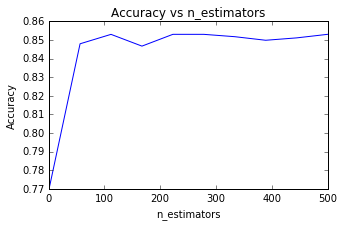

In [39]:
#Plotting
plt.figure(figsize=(5, 3))
plt.title("Accuracy vs n_estimators")
plt.plot(n_estimators_values,acc_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

We can see that the graph is getting stabilized around the value of n_estimators=100, so we will keep that value.

In [177]:
#Max depth
max_depth_val=[1,5,10,20,30,40,50]
acc_max_depth=[]
for i in max_depth_val:
    rfc=RandomForestClassifier(n_estimators=100,max_depth=i)
    acc_max_depth.append(np.mean(sklearn.cross_validation.cross_val_score(rfc, x, y, cv=10,scoring='accuracy')))

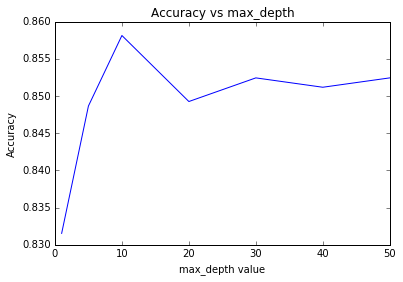

In [178]:
#Plotting
plt.title("Accuracy vs max_depth")
plt.plot(max_depth_val,acc_max_depth)
plt.xlabel('max_depth value')
plt.ylabel('Accuracy')
plt.show()

We can see that the graph is getting stabilized by the value of 10, so we will keep that value

In [180]:
#Max_features
max_features_val=range(1,x.shape[1],1)
acc_max_features=[]
for i in max_features_val:
    rfc=RandomForestClassifier(n_estimators=100,max_depth=10,max_features=int(i))
    acc_max_features.append(np.mean(sklearn.cross_validation.cross_val_score(rfc, x, y, cv=10,scoring='accuracy')))

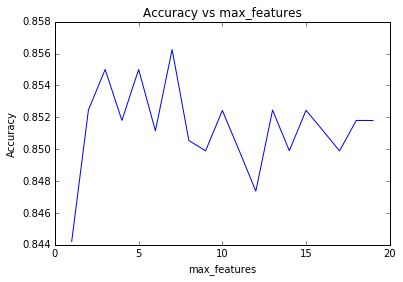

In [181]:
#Plotting
plt.title("Accuracy vs max_features")
plt.plot(max_features_val,acc_max_features)
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.show()

We will take a value of max_features=3

In [220]:
#Training Random Forest with the parameters that were found
rfc=RandomForestClassifier(n_estimators=100,max_depth=10,max_features=3)

In [183]:
#Taking a look at the cross validation to see if the model is overfitting or not (we are considering a k_fold=20)
sklearn.cross_validation.cross_val_score(rfc, x, y, cv=20, scoring='accuracy')

array([ 0.7875    ,  0.875     ,  0.85      ,  0.8625    ,  0.85      ,
        0.85      ,  0.81012658,  0.86075949,  0.87341772,  0.88607595,
        0.79746835,  0.91139241,  0.83544304,  0.88461538,  0.84615385,
        0.88461538,  0.83333333,  0.87179487,  0.85897436,  0.88461538])

In [297]:
#Confusion matrix
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.40)
rfc =rfc.fit(X_train, y_train)
y_predict=rfc.predict(X_test)
cm=confusion_matrix(y_test, y_predict)
accuracy=sum(y_test==y_predict)/(len(y_test))*100
print('Accuracy: %f%%' % accuracy)

Accuracy: 85.917722%


The following code was adapted from: 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

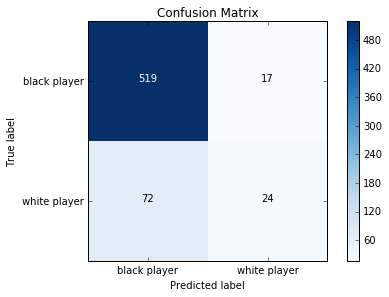

In [298]:
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['black player','white player'])
plt.yticks(tick_marks, ['black player','white player'])
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [188]:
#Feature importance
rfc =rfc.fit(x, y)
importances = rfc.feature_importances_
indices=sorted(range(len(importances)), key=lambda k: importances[k],reverse=True)

print("Feature ranking:")
for n_index in range(len(indices)):
    print("%d.- %s: %f" % (n_index + 1, columns_x[indices[n_index]], importances[indices[n_index]]))

Feature ranking:
1.- seIAT: 0.114161
2.- seExp: 0.093069
3.- meanExp: 0.088946
4.- meanIAT: 0.077901
5.- nExp: 0.059293
6.- nIAT: 0.053079
7.- club: 0.047088
8.- leagueCountry: 0.046737
9.- refCountry: 0.045462
10.- goals: 0.043655
11.- victories: 0.043327
12.- yellowCards: 0.041111
13.- ties: 0.039583
14.- games: 0.039232
15.- defeats: 0.038858
16.- weight: 0.037125
17.- height: 0.032058
18.- position: 0.029231
19.- yellowReds: 0.016022
20.- redCards: 0.014063


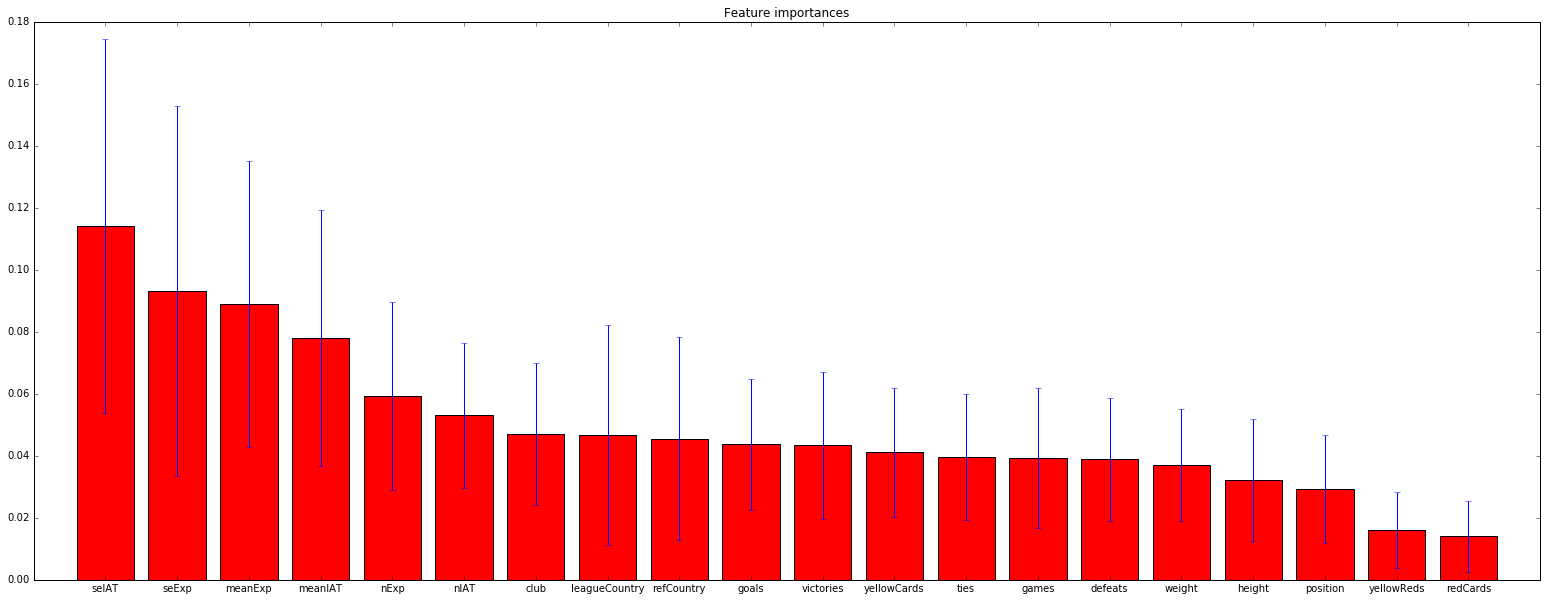

In [189]:
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],axis=0)

#Plotting the important features
plt.figure(figsize=(27, 10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],yerr=std[indices],align="center",color='r')
plt.xticks(range(len(indices)),(columns_x[i] for i in indices))
plt.xlim([-1, len(indices)])
plt.show()

We can see that the most important features are those who contain "biased" values, let's drop them and see what we get.

In [201]:
x_no_bias=x.drop(['seIAT','seExp','meanExp','meanIAT','nExp','nIAT'], 1)
x_no_bias_columns=x_no_bias.columns

In [202]:
rfc_no_bias=RandomForestClassifier(n_estimators=100,max_depth=10,max_features=3)
#We perform the cross validation just to see the accuracy
sklearn.cross_validation.cross_val_score(rfc_no_bias, x_no_bias, y, cv=20, scoring='accuracy')

array([ 0.875     ,  0.825     ,  0.8375    ,  0.85      ,  0.8375    ,
        0.85      ,  0.82278481,  0.84810127,  0.84810127,  0.84810127,
        0.82278481,  0.87341772,  0.81012658,  0.84615385,  0.84615385,
        0.85897436,  0.83333333,  0.84615385,  0.84615385,  0.85897436])

In [211]:
rfc =rfc_no_bias.fit(x_no_bias, y)
importances = rfc_no_bias.feature_importances_
indices=sorted(range(len(importances)), key=lambda k: importances[k],reverse=True)

print("Feature ranking:")
for n_index in range(len(indices)):
    print("%d.- %s: %f" % (n_index + 1, x_no_bias_columns[indices[n_index]], importances[indices[n_index]]))

Feature ranking:
1.- victories: 0.094203
2.- games: 0.086333
3.- goals: 0.085495
4.- refCountry: 0.085160
5.- club: 0.084530
6.- defeats: 0.079569
7.- leagueCountry: 0.078907
8.- yellowCards: 0.077857
9.- weight: 0.072527
10.- ties: 0.071248
11.- height: 0.067408
12.- position: 0.054465
13.- redCards: 0.031912
14.- yellowReds: 0.030387


It seems that the order of the important features did not change so much, now we can see that the features victories and games are leading the feature ranking but the other features are still in the same position 

## Bonus 
Learning Curves: Cross Validation 

## 2. Clustering
### Feature Removal

# Stuff People have done/Discussions on Slack:

## First Discussion -- Input features
Ismail Bensouda Koraichi	[7:48 PM]  
Hello, I would like to clarify something. In the first question of the homework : " [...] given a soccer player description outputs his skin color", what does "soccer player description" mean ? I mean what should be the input ? A dyad ? An aggregation of multiple dyads ?

Gael Lederrey	[9:24 PM]  
@ismail64 I think that we'll have to aggregate the data by players.. But then, we loose some information (the IAT and Exp for examples).. Therefore, it can be interesting to create a new feature taking into account the removed feature..

But maybe there's another way to deal with the data without aggregating them.. =)

Dunai Fuentes Hitos	[11:31 PM]  
I went with the aggregation by player.
The "smart" way to deal with those features (IAT, Exp, etc.) would be to make a correction upon the number of yellow and red cards received by the player, as this is the only link players have to the referee...
But it all looks a bit far-fetched, so I particularly decided to remove all this data under a presumption of honesty (the referee's honesty) (edited)

Gael Lederrey	[11:57 PM]  
@dunai That's what I did too.. ^^ 
But I'm pretty sure racism exists everywhere. So I just created a weighted sum for the cards, the referees' "racism" values, and the number of times they encountered a player.. This gives you sort of a score linking the _IAT_ and the _Exp_ to all the referees who encounter a player..

At the end, I'm pretty sure that it's important to keep these values.. Because the other values (goals, height, weight, games, etc.) can't be linked to the color of a player.. So, there's only these two "racism" values linked to the number of cards that can maybe give some information..

If someone has another idea, I'd be glad to read about it.. =) (edited)



## Second Discussion - Aggregating Features

Jonas Racine	[3:39 PM]  
hey guys, is anyone able to get much more than ~70% accuracy on the homework? (exercise 1)

bojan.petrovski	[3:42 PM]  
I got something like 78-80

[3:43]  
But I'm aggregating the results by player

Gael Lederrey	[3:53 PM]  
@bojan.petrovski Did you create new features using the ones we loose (Like the IAT and Exp)?

bojan.petrovski	[4:14 PM]  
Yeah for the IATmean and EXPmean I averaged them and for IATstd and EXPstd I calculated the Stadndard deviation on the samples that I used for the new means, because you can't just average standard deviations

## Third Discussion - Dealing with Categorical Features

Paul Nicolet	[10:01 AM]  
Hey guys I’m curious to know if you have a good way to deal with the categorical features in the homework, as `scikit-learn` doesn’t accept them as strings. I figured out a way to encode them using the `OneHotEncoder()` class, in order to get a vector representation of each category, but I have some issues to deal with these vectors now, given a DataFrame doesn’t accept vectors as values… The easy way would be to encode them as integers but it’s risky because it could be interpreted as continuous and ordered data right ?

arnaudmiribel	[10:05 AM]  
We’ve used `LabelEncoder()` which naïvely binds labels to integers values. There are some issues doing this as two successive cells will be numerically _closer_ than two far apart cells (whereas there is no reason for this), so I’d also welcome any hint on this

Baptiste Billardon	[10:08 AM]  
From what I read, there are no implementation of random forest in sklearn that handles categorical features. I also labelEncoded the categorical features then oneHotEncoded them

Ondine Chanon	[11:20 AM]  
And what about dummy variables? It increases the number of attributes, but at least each cell has equal importance and there is no ordering issue.

Ciprian Tomoiaga	[3:53 PM]  
@bojan.petrovski what would be the reason for averaging IATmean (or EXPmean) ?

[3:55]  
I mean, it's great that you get a good score, but it doesn't make much sense to me to average independent values. I mean, they are not related to the player, but to the referee

Alexis Semple	[4:25 PM]  
Hey guys, I wonder how you understood the first sentence of the description for exercise 2 in this homework:
> Aggregate the _referee information_ grouping by soccer player
Maybe I'm missing something, but it seems to me that this indicates that we should not use features relevant only to the player himself (e.g. height, weight, position...) (edited)

Gianrocco Lazzari	[4:49 PM]  
well, in principle I don’t see what you should exclude them…it’s about reducing the variability across referees (the way I understand it) - it might  be that  player-dependent-features are still relevant (edited)

bojan.petrovski	[5:19 PM]  
@cipri_tom well in an ideal world the distribution of red and yellow cards should only depend on the position of the player, i.e. defenders are more likely to make a serious offence. So the cards alone should not help in any way to distinguish between black and white players. My idea is that some referees have a bias so the distribution is not the same for black and white players. And the average of the IAT just gives you a very crude idea of how much the player was discriminated against. For example if the average IAT is high and the player is black I would expect the distribution of cards for that player to be very different and if the IAT is low than you would expect the difference to be small in relation to the distribution for white players. I saw some people mention doing a weighted average based on the number of cards, but I think that in that way you are skewing the average because the lack of a card is also valuable information. (edited)

[5:20]  
But again it's hard to tell if the model is actually doing this kind of prediction or is picking up on some other factors